In [1]:
import pandas as pd
from transformers import ElectraTokenizer, TFElectraForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras_tuner as kt
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import json

2024-06-26 15:46:10.047685: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 15:46:10.954255: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 데이터 합치기

In [2]:
data1 = pd.read_csv('./data/train.csv', index_col = 'idx')
data2 = pd.read_csv('./data/normal_conversation.csv', index_col = 'idx')

In [3]:
data = pd.concat([data1, data2])
print(len(data1), len(data2), len(data))
data.head()

3950 997 4947


,class,conversation
idx,,
0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


# 데이터 라벨링

In [4]:
label_map = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}

data['class'] = data['class'].apply(lambda x: label_map[x])
data.head()

,class,conversation
idx,,
0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


# 데이터 전처리

In [5]:
# KoELECTRA 토크나이저 로드
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

# 데이터를 KoELECTRA 입력 형식으로 변환하는 함수 정의
def convert_to_input(df, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []
    labels = []

    for i in range(len(df)):
        sentence = df.iloc[i]['conversation'].replace('.', '').replace('\n', '')
        encoded = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        labels.append(df.iloc[i]['class'])

    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_masks
    }, labels

In [6]:
train_df, test_df = train_test_split(data, test_size = 0.2, random_state = 526)

In [7]:
# 데이터셋 변환
train_inputs, train_labels = convert_to_input(train_df, tokenizer)
test_inputs, test_labels = convert_to_input(test_df, tokenizer)

# TF Dataset 생성
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).batch(16)
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels)).batch(16)

2024-06-26 15:46:13.220172: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20699 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:02:00.0, compute capability: 8.6


# 모델 학습

In [8]:
model = TFElectraForSequenceClassification.from_pretrained(
    "monologg/koelectra-base-v3-discriminator", num_labels = len(label_map), from_pt = True)
model.summary()

2024-06-26 15:46:22.914778: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'electra.embeddings.position_ids', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing TFElectraForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassif

Model: "tf_electra_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 electra (TFElectraMainLaye  multiple                  112330752 
 r)                                                              
                                                                 
 classifier (TFElectraClass  multiple                  594437    
 ificationHead)                                                  
                                                                 
Total params: 112925189 (430.78 MB)
Trainable params: 112925189 (430.78 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
# 옵티마이저, 손실 함수 설정
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

In [10]:
# 모델 컴파일
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [11]:
# 조기 종료 콜백 설정
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# 모델 훈련
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    callbacks=[early_stopping]
)

Epoch 1/10


2024-06-26 15:46:49.822243: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7426c9621560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-26 15:46:49.822281: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-06-26 15:46:49.829370: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-26 15:46:49.851182: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-06-26 15:46:50.032929: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


248/248 [==============================] - 115s 277ms/step - loss: 0.8852 - accuracy: 0.6899 - val_loss: 0.4098 - val_accuracy: 0.8576
Epoch 2/10
248/248 [==============================] - 37s 149ms/step - loss: 0.3320 - accuracy: 0.8936 - val_loss: 0.3377 - val_accuracy: 0.8949
Epoch 3/10
248/248 [==============================] - 36s 147ms/step - loss: 0.1691 - accuracy: 0.9487 - val_loss: 0.3609 - val_accuracy: 0.9020
Epoch 4/10
248/248 [==============================] - 37s 148ms/step - loss: 0.1184 - accuracy: 0.9679 - val_loss: 0.4803 - val_accuracy: 0.8768
Epoch 5/10
248/248 [==============================] - 37s 148ms/step - loss: 0.1152 - accuracy: 0.9674 - val_loss: 0.3520 - val_accuracy: 0.9030


In [12]:
# 모델 평가
eval_results = model.evaluate(test_dataset)
print(f"테스트 세트 정확도: {eval_results[1] * 100:.2f}%")

 3/62 [>.............................] - ETA: 3s - loss: 0.4429 - accuracy: 0.8333

62/62 [==============================] - 4s 60ms/step - loss: 0.3377 - accuracy: 0.8949
테스트 세트 정확도: 89.49%


In [13]:
# 평가
predictions = model.predict(test_dataset)
predicted_labels = tf.argmax(predictions.logits, axis=1).numpy()
true_labels = test_labels.numpy()

62/62 [==============================] - 6s 59ms/step


In [14]:
print(classification_report(true_labels, predicted_labels, target_names=label_map.keys()))

              precision    recall  f1-score   support

       협박 대화       0.92      0.76      0.83       189
       갈취 대화       0.80      0.95      0.87       193
 직장 내 괴롭힘 대화       0.88      0.95      0.92       192
   기타 괴롭힘 대화       0.90      0.83      0.86       228
       일반 대화       0.99      0.99      0.99       188

    accuracy                           0.89       990
   macro avg       0.90      0.90      0.90       990
weighted avg       0.90      0.89      0.89       990



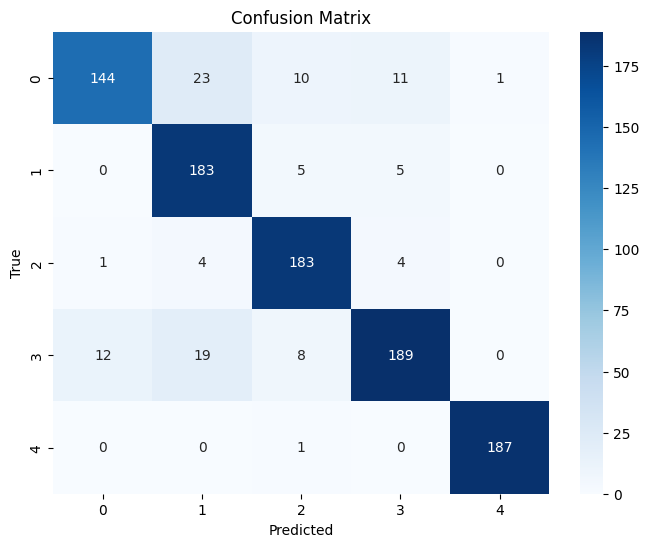

In [15]:
label_map = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}
labels = label_map.values()

cm = confusion_matrix(test_labels, predicted_labels)

# Heatmap으로 confusion matrix 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [16]:
file_path = './data/test.json'

with open(file_path, 'r', encoding = 'utf-8') as f:
    json_data = json.load(f)

data = []

for sample in json_data:
    data.append({'idx': sample, 'conversation': json_data[sample]['text']})

data = pd.DataFrame(data)
data.head()

,idx,conversation
0,t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
1,t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
3,t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
4,t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...


In [17]:
data['conversation'][0]

'아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나보네 그럼 취소할까요 아가씨 내 여기단골이니 담에 갖다줄께 저도 알바생이라 외상안됩니다 아따 누가 떼먹는다고 그러나 갖다준다고 안됩니다 자꾸이럼 경찰불러요 아가씨 담배피는교 그건 왜 물으세요 그람 아가씨 담배 한대만 빌립시다 내 지금 지갑도 잃어버리고 기분이 그래서 그러니 여기요  아따 주는김에 한개더 주면 되겠네'

In [18]:
# 테스트 데이터 전처리 함수 정의
def convert_test_to_input(df, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []

    for i in range(len(df)):
        sentence = df.iloc[i]['conversation'].replace('.', '').replace('\n', '')
        encoded = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_masks
    }

# 테스트 데이터셋 변환
test_inputs = convert_test_to_input(data, tokenizer)

# TF Dataset 생성
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs)).batch(16)

In [19]:
# 평가
predictions = model.predict(test_dataset)
predicted_labels = tf.argmax(predictions.logits, axis=1).numpy()

32/32 [==============================] - 5s 59ms/step


In [20]:
print(predicted_labels)

[1 2 2 4 2 0 0 1 4 1 0 4 2 2 2 0 4 4 0 3 0 3 3 1 1 2 1 4 2 1 1 1 4 1 0 1 3
 1 0 1 0 1 1 1 4 2 0 3 4 0 1 3 1 2 2 3 3 4 3 3 1 3 0 3 2 0 4 3 4 1 3 2 3 2
 0 2 2 1 2 3 1 0 4 0 3 2 1 4 1 2 2 2 0 3 4 2 1 2 1 2 1 1 4 0 2 2 2 3 4 1 4
 0 1 2 1 1 4 2 2 1 2 3 1 1 1 1 1 4 1 4 3 3 2 3 1 0 3 0 3 4 0 3 1 3 2 0 0 0
 0 1 0 0 4 1 2 4 0 2 3 3 0 3 2 0 2 3 2 4 3 1 0 2 2 3 3 3 0 2 1 3 2 3 2 2 3
 4 3 0 1 0 0 3 1 3 1 3 0 4 3 3 2 0 3 3 0 3 2 2 2 2 4 1 3 2 1 4 4 4 0 0 1 2
 0 4 1 4 1 0 1 1 2 0 3 3 1 3 3 1 0 3 3 3 3 2 4 1 2 1 2 1 1 3 0 2 2 1 4 2 1
 2 1 3 1 3 2 3 3 4 3 1 1 3 0 2 4 2 2 3 2 2 1 0 3 2 4 2 1 2 1 2 1 1 3 3 2 3
 4 3 1 0 2 3 0 2 1 1 3 2 1 2 0 1 3 4 2 3 1 3 3 0 2 0 0 1 1 1 1 4 2 3 1 0 0
 3 1 4 1 1 4 3 0 2 0 0 1 2 3 1 0 0 0 3 1 1 1 3 3 3 1 1 3 1 1 1 2 4 3 1 3 1
 1 2 0 2 2 3 1 3 1 1 2 0 2 2 3 1 4 0 0 3 1 0 1 2 1 2 0 4 1 0 3 3 2 2 3 0 2
 1 2 1 3 4 1 2 4 4 3 4 1 2 1 0 3 3 3 1 1 2 2 0 3 4 1 0 1 3 0 4 4 2 3 0 2 3
 4 2 0 2 2 4 4 0 1 3 2 1 2 3 1 1 2 1 2 2 2 1 4 2 4 0 2 1 0 4 0 2 1 1 4 2 4
 3 1 0 1 3 3 4 4 0 3 4 0 

In [21]:
submission = pd.read_csv('./data/new_submission.csv')
submission.head()

,file_name,class
0,t_000,NaN
1,t_001,NaN
2,t_002,NaN
3,t_003,NaN
4,t_004,NaN


In [22]:
submission['class'] = predicted_labels
submission.to_csv('new_submission.csv')